<a href="https://colab.research.google.com/github/eecoubrough/Keras_Assignment/blob/main/Part_3_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Medical Image Analysis Example
A simple convolutional neural network model trained using a simple pathology image dataset.

To use GPU acceleration make sure to change your runtime type in Google Colab to GPU.

## Python Imports
This section loads the necessary python packages to the instance.

In [120]:
# Built-in Imports
import random

In [121]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [122]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the BloodMNIST dataset as a NumPy array object to the Google Colab instance. Note that the dataset does need to be redownloaded every time an instance is created.


In [123]:
# The dataset selected is PneumoniaMNIST
# If desired, a different MedMNIST dataset could be used simply by specifying the desired dataset name.
DATA_NAME = "PneumoniaMNIST"

In [124]:
# Retrieves the dataset from GitHub
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2024-03-31 14:25:48--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py.5’

info.py.5           100%[===================>]  27.12K  --.-KB/s    in 0.001s  

2024-03-31 14:25:48 (32.9 MB/s) - ‘info.py.5’ saved [27766/27766]



In [125]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

In [126]:
# Loads the downloaded NumPy object, saving it to the variable 'dataset'.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_x = np.expand_dims(train_x, axis=-1)
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_x = np.expand_dims(val_x, axis=-1)
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_x = np.expand_dims(test_x, axis=-1)
test_y = dataset["test_labels"]

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [127]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset (used to check the distributions of data in each of the eight classes to ensure there is no unexpected discepencies).
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


3774: normal


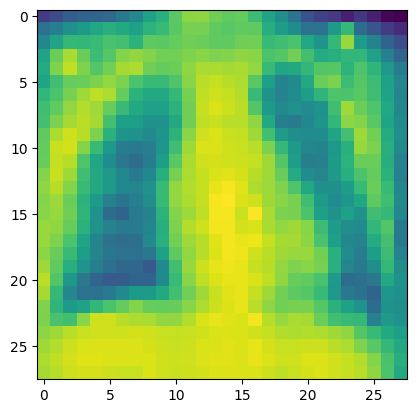

In [128]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

In [129]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True,
                                    vertical_flip=True)

In [130]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.

In [131]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutional layers into a one-dimensional array.
flatten = layers.Flatten()(pool_2)

#
dense = layers.Dense(units=16, activation="relu")(flatten)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=1, activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001))(dense)

# Initializes the defined model.
model = Model(inputs=input, outputs=output, name="Model")
# Print the model summary.
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 5, 5, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 800)               0     

## Model Training
This is where we define the training options and then train the model.

Through testing different values for the training parameters, I determined that a smaller batch size and more epochs was optimum.


In [138]:
# Defining the parameters used during training.
BATCH_SIZE = 64 #Batch size should always be a power of 2 GPU allocation purposes (quicker as no additional calculations required by the computer)
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [139]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])

In [140]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, val_y, batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
73/73 [==============================] - 6s 67ms/step - loss: 0.6852 - accuracy: 0.5773 - val_loss: 0.6542 - val_accuracy: 0.7137
Epoch 2/10
73/73 [==============================] - 3s 40ms/step - loss: 0.6360 - accuracy: 0.7298 - val_loss: 0.6287 - val_accuracy: 0.7424
Epoch 3/10
73/73 [==============================] - 3s 41ms/step - loss: 0.6101 - accuracy: 0.7419 - val_loss: 0.6058 - val_accuracy: 0.7424
Epoch 4/10
73/73 [==============================] - 4s 60ms/step - loss: 0.5934 - accuracy: 0.7421 - val_loss: 0.5904 - val_accuracy: 0.7424
Epoch 5/10
73/73 [==============================] - 3s 41ms/step - loss: 0.5787 - accuracy: 0.7421 - val_loss: 0.5803 - val_accuracy: 0.7424
Epoch 6/10
73/73 [==============================] - 3s 41ms/step - loss: 0.5662 - accuracy: 0.7421 - val_loss: 0.5635 - val_accuracy: 0.7424
Epoch 7/10
73/73 [==============================] - 3s 43ms/step - loss: 0.5538 - accuracy: 0.7421 - val_loss: 0.5538 - val_accuracy: 0.7424
Epoch 8/10
73

## Plot Learning Curves
This is where we visualise the training of the model.

In [141]:
from tabulate import tabulate

# Extract training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Create a list of lists containing the data
data = [
    ["Epoch", "Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"]
]

for epoch, (tr_loss, tr_acc, val_loss, val_acc) in enumerate(zip(training_loss, training_accuracy, validation_loss, validation_accuracy), start=1):
    data.append([epoch, tr_loss, tr_acc, val_loss, val_acc])

# Display the data using tabulate
print(tabulate(data, headers="firstrow", tablefmt="grid"))

+---------+-----------------+---------------------+-------------------+-----------------------+
|   Epoch |   Training Loss |   Training Accuracy |   Validation Loss |   Validation Accuracy |
+=========+=================+=====================+===================+=======================+
|       1 |        0.685239 |            0.577315 |          0.654202 |              0.71374  |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       2 |        0.636031 |            0.729822 |          0.628686 |              0.742366 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       3 |        0.61011  |            0.741929 |          0.605774 |              0.742366 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       4 |        0.593353 |            0.742141 |          0.5904   |              0.742366 |
+---------+-----------------+-----------

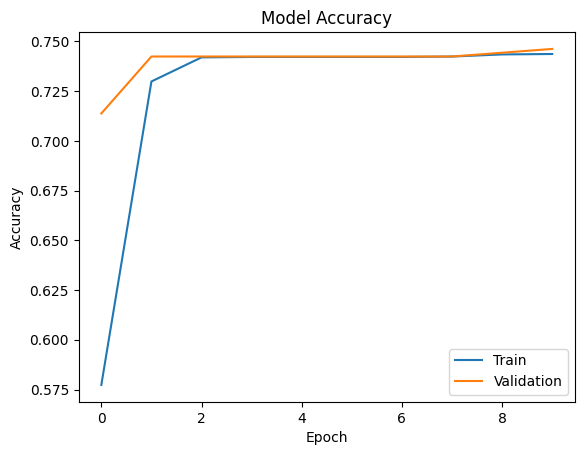

In [142]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

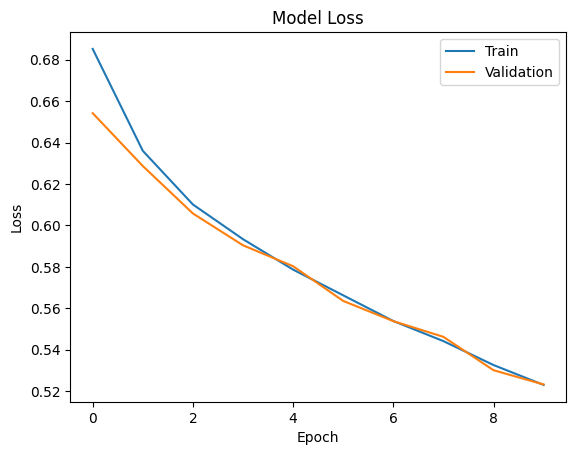

In [143]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()